# 2018-12-18 - Grid Searching for STDP
Après une petite pause pour motif de ligaments de la main arrachés, on s'attaqu a faire un grid search uniquement sur les paramètres temporelles de la STDP. L'idéal serait de plotter les temps et amplitudes ou les temps et ratio (deux a deux en tout cas) en fonction du delta final, pour montrer que l'apprentissage ne peut prendre qu'une seule forme, idéalement la notre

## Et plutot que de fixer les params sur les scans d'avant je vais les fixer a partir d'un papier de neurobio *
Pour une review plutot chouette, voir Synaptic Learning Rules, Cortical Circuits and Vision

# Init

In [1]:
import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import lmfit
import matplotlib.gridspec as gridspec

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [2]:
def fit_gaussian(popsize, spike_array, seq_nbr=None):
    '''
    calculates a spike array gaussian lmfit profile and plots it
    '''
    # fit the gaussian
    x = np.linspace(0, popsize, popsize)
    y = spike_array

    mod = GaussianModel()
    pars = mod.guess(y, x=x)

    out = mod.fit(y, pars, x=x)
    # print(out.fit_report())
    # eye cancer-triggering lines
    sigma = out.best_values['sigma']

    return sigma


def tuning_function(i, j, B, N):  # von mises
    if B == np.inf:
        VM = np.ones_like(i*j)
    else:
        VM = np.exp((np.cos(2.*((i-j)/N*np.pi))-1)/(B*np.pi/180)**2)
    VM /= VM.sum(axis=0)
    return VM


def cut_spiketrain(array, window):
    '''
    Cut a spiketrain array between window*500 and window+1 *500
    we use it to only visualize a specific time window of the network
    '''
    spiketrain_len = []
    for spiketrain in np.asarray(array.spiketrains):
        spiketrain_array = np.array(spiketrain, dtype=float)

        spiketrain_cut = np.where(
            (spiketrain_array > window*500) & (spiketrain_array < (window+1)*500))[0]

        spiketrain_len.append(len(spiketrain_cut))

    spikelen_array = np.asarray(spiketrain_len)
    return spikelen_array

In [3]:
def SuperScanner(SpikesP, SpikesE, SpikesI,
                 popsize, rates, simtime):

    sigma_zero = fit_gaussian(popsize, cut_spiketrain(SpikesE, 0), seq_nbr=1)
    sigma_one = fit_gaussian(popsize, cut_spiketrain(SpikesE, 1), seq_nbr=2)
    sigma_two = fit_gaussian(popsize, cut_spiketrain(SpikesE, 2), seq_nbr=3)
    sigma_f = fit_gaussian(popsize, cut_spiketrain(SpikesE, 3), seq_nbr=4)

    return [sigma_zero, sigma_one, sigma_two, sigma_f]

# Hyperparameters

In [4]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 2000
rng = sim.NumpyRNG(seed=42)

rate_gain = 10.  # multiplier for the rates
angle_input = 40  # degrees
b_theta = 30  # degrees
sparseness = .1

# First scan : Taus constant, with 1 to 1 ratio, against A multiplier

In [5]:
from sklearn.model_selection import ParameterGrid

scan_size = 25
parameters_dico = {'sparseness': np.array([.1]),  #scanned
                   'weight_mu': np.array([1.5]), #scanned
                   'delays_mu': np.array([1.]), #scanned
                   'ratio_weights_EI': np.array([1]), #scanned
                   'stdp_weight_init': np.array([.5]), #scanned
                   'stdp_max_weight': np.array([1]), #scanned
                   'ratio_amps': np.array([1]),
                   'ratio_taus': np.array([1]),
                   'taus': np.linspace(5, 60, scan_size),
                   'stdp_amps': np.linspace(.001, .01, scan_size)}
# ratio multiply the negative part of the duo, ie inhibition, tau minus and A minus

grid = ParameterGrid(parameters_dico)

In [6]:
import datetime

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d-%Hh%M")

# a+ to append and create if not existant
f = open("./output/scan_logs_%s.txt" % strtime, "a+")
f.write('SCANNING PARAMETERS @ '+strtime)
f.close()

In [7]:
def run_simulation(sparseness, weight_mu, delays_mu,
                   tau, stdp_amp, stdp_weight_init, stdp_max_weight,
                   ratio_weights_EI, ratio_amps, ratio_taus,
                   filewrite, full_args):

    def vary_angle(t):
        simtime = 2000
        n_pop = 60
        shift = 40

        angle = 1. * np.arange(n_pop)
        rates = tuning_function(
            angle, (t*shift)+(angle_input)/180.*n_pop, b_theta, n_pop)
        rates /= rates.mean()
        rates *= rate_gain
        for i, cell in enumerate(input_pop):
            cell.set_parameters(rate=rates[i])
        return t + simtime/4

    # WEIGHTS
    normal_weights = rnd('normal_clipped', mu=weight_mu, sigma=.2, low=0.1,
                         high=5,
                         rng=rng)
    inh_normal_weights = rnd('normal_clipped', mu=weight_mu*ratio_weights_EI, sigma=.2, low=0.1,
                             high=5,
                             rng=rng)

    # DELAYS
    delays = rnd('normal_clipped', mu=delays_mu, sigma=.2, low=0.1,
                 high=5,
                 rng=rng)

    # STDP
    timing_dependence = sim.SpikePairRule(tau_plus=tau, tau_minus=tau*ratio_taus,
                                          A_plus=stdp_amp, A_minus=stdp_amp*ratio_amps)

    sim.setup(timestep=.1, threads=8)

    # POPULATIONS
    exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Exictateurs")

    inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Inhibiteurs")

    input_pop = sim.Population(n_pop,
                               sim.SpikeSourcePoisson(
                                   rate=500, duration=simtime, start=250),
                               label="Entree Orientation")

    stabilizing_pop = sim.Population(n_pop,
                                     sim.SpikeSourcePoisson(
                                         rate=10, duration=200, start=0),
                                     label="Entree Orientation")

    # SYNAPSES
    STDP_syn = sim.STDPMechanism(
        timing_dependence=timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=stdp_max_weight),
        weight=stdp_weight_init,
        delay=delays,
        dendritic_delay_fraction=1.)

    # Intras
    syn_exc_exc = sim.Projection(exc, exc,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_inh = sim.Projection(inh, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=sim.StaticSynapse(
                                     weight=normal_weights, delay=delays),
                                 receptor_type='inhibitory')  # we can't have two types of synapses now can we ?

    # Inters
    syn_exc_inh = sim.Projection(exc, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_ex = sim.Projection(inh, exc,
                                connector=sim.FixedProbabilityConnector(
                                    sparseness, rng=rng),
                                synapse_type=sim.StaticSynapse(
                                    weight=normal_weights, delay=delays),
                                receptor_type='inhibitory')

    # Input
    syn_inp_exc = sim.Projection(input_pop, exc,
                                 connector=sim.OneToOneConnector(),
                                 synapse_type=sim.StaticSynapse(
                                     weight=1, delay=1),
                                 receptor_type='excitatory')
    sin_stab_exc = sim.Projection(stabilizing_pop, exc,
                                  connector=sim.OneToOneConnector(),
                                  synapse_type=sim.StaticSynapse(
                                      weight=1, delay=1),
                                  receptor_type='excitatory')

    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates *= rate_gain
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    exc.record('spikes')
    inh.record('spikes')
    input_pop.record('spikes')
    sim.run(simtime, callbacks=[vary_angle])
    sim.end()

    exc_data = exc.get_data().segments[0]
    inh_data = inh.get_data().segments[0]
    inp_data = input_pop.get_data().segments[0]

    scan_lst = SuperScanner(SpikesP=inp_data, SpikesE=exc_data, SpikesI=inh_data,
                            popsize=60, rates=rates, simtime=2000)

    # logging
    f = open(filewrite, "a+")
    f.write('\nSigmas\n')
    f.write(str(scan_lst))
    f.write('\nParams\n')
    f.write(str(full_args))
    f.write('\n\n')
    f.close()

    sim.reset()
    return scan_lst, tau, stdp_amp

In [8]:
import datetime
from tqdm import tqdm

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d-%Hh%M")

scan_output = []
for combination in tqdm(grid):
    sigmas, tau, a = run_simulation(sparseness=combination['sparseness'],
                                  weight_mu=combination['weight_mu'],
                                  delays_mu=combination['delays_mu'],
                                  tau=combination['taus'],
                                  stdp_amp=combination['stdp_amps'],
                                  stdp_weight_init=combination['stdp_weight_init'],
                                  stdp_max_weight=combination['stdp_max_weight'],
                                  ratio_weights_EI=combination['ratio_weights_EI'],
                                  ratio_amps=combination['ratio_amps'],
                                  ratio_taus=combination['ratio_taus'],
                                  filewrite='./output/scan_logs_%s.txt' % strtime,
                                  full_args=combination)
    scan_output.append([sigmas, tau, a])

  0%|          | 1/625 [00:01<15:01,  1.44s/it]/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/recording/__init__.py:264: UserWarning: Recorded at least one spike after t_stop
  warn("Recorded at least one spike after t_stop")
100%|██████████| 625/625 [16:13<00:00,  1.45s/it]


In [9]:
scan_output = np.asarray(scan_output)

np.save('./output/scan_results_%s.npy' % strtime,
        scan_output)

scan_output = np.load('./output/scan_results_2018-12-19-13h26.npy')

In [11]:
sigmas_zero, sigmas_f, delta_sigmas, taus, As = [],[],[], [],[]
for scan in scan_output :
    sigma_zero = scan[0][0]
    sigma_f = scan[0][-1]
    delta_sigma = sigma_zero - sigma_f
    
    sigmas_zero.append(sigma_zero)
    sigmas_f.append(sigma_f)
    delta_sigmas.append(delta_sigma)
    
    taus.append(scan[1])
    As.append(scan[-1])
    
sigmas_zero = np.asarray(sigmas_zero)
sigmas_f = np.asarray(sigmas_f)
delta_sigmas = np.asarray(delta_sigmas)

Text(0.5, 0, 'Run nbr')

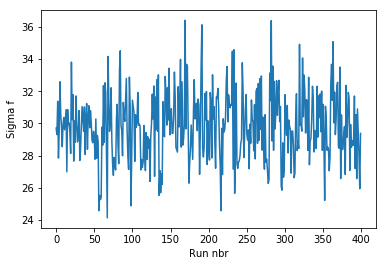

In [12]:
plt.plot(sigmas_f)
plt.ylabel('Sigma f')
plt.xlabel('Run nbr')

Text(0.5, 1.0, 'Il manque une dimension pour expliquer la superposition en ordonnée')

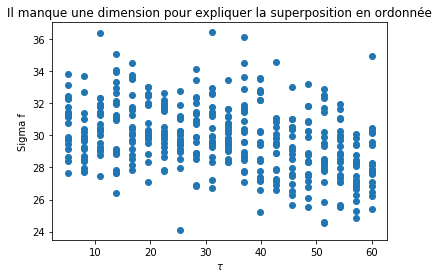

In [13]:
plt.scatter(taus, sigmas_f)
plt.xlabel('$\\tau$')
plt.ylabel('Sigma f')
plt.title('Il manque une dimension pour expliquer la superposition en ordonnée')

Text(0.5, 1.0, 'Visualisation orthogonale')

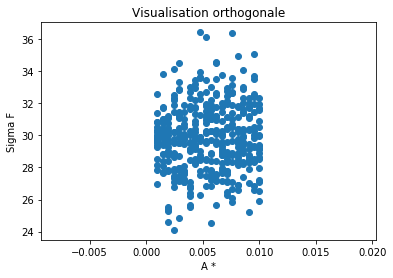

In [14]:
plt.scatter(As, sigmas_f)
plt.xlabel('A *')
plt.ylabel('Sigma F')
plt.title('Visualisation orthogonale')

In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


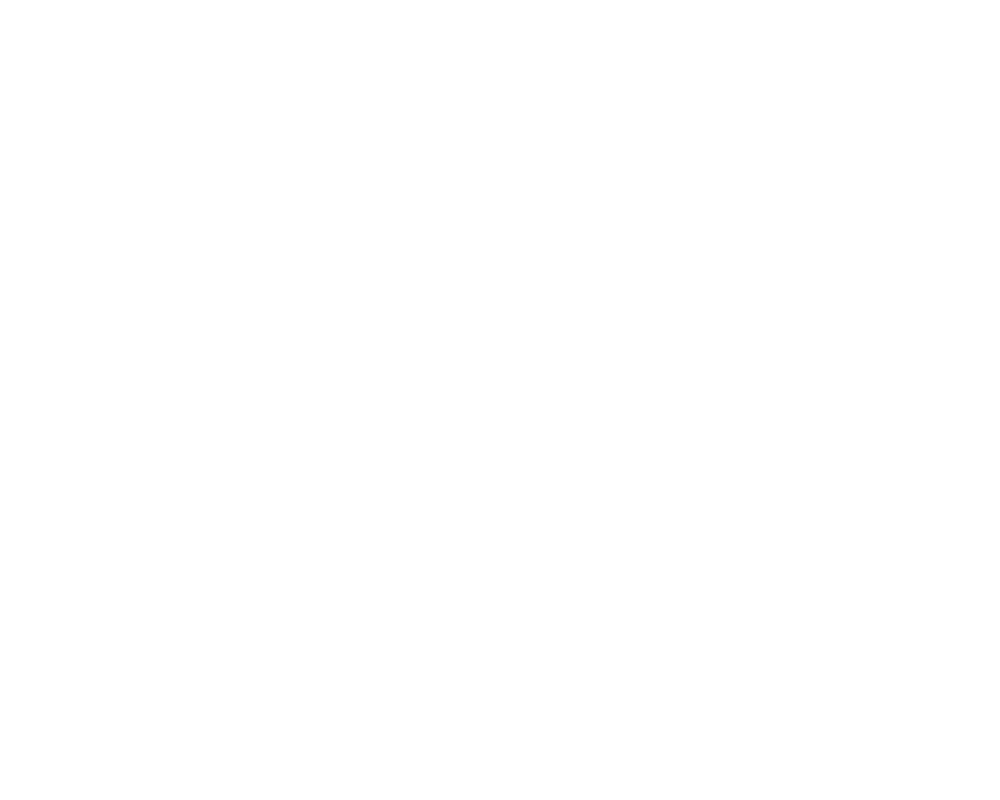

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

vislim = 25

# un peu de masking
'''sigmas_zero[sigmas_zero > vislim] = np.nan
sigmas_f[sigmas_f > vislim] = np.nan
delta_sigmas[delta_sigmas > vislim] = np.nan'''


tri = ax.plot_trisurf(As,
                   taus,
                   sigmas_f,
                   #c=np.linspace(min(sigmas_f), max(sigmas_f), sigmas_f.shape[0]),
                   cmap=plt.cm.viridis,
                   linewidth=0)


ax.set_zlabel('$\sigma_f$', fontsize=20)
ax.set_xlabel('A *', fontsize=20)
ax.set_ylabel('taus', fontsize=20)

ax.xaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
ax.yaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
#ax.zaxis._axinfo["grid"]["color"] = (1,1,1,0)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



plt.colorbar(tri)
ax.set_title('Gradient des performances du réseau')
ax.view_init(elev=90,azim = 0)
#plt.savefig('./figs/2018_12_18_Perf_gradient.pdf', format = 'pdf', dpi = 200)

# Smoothing signal for a good figure

In [17]:
def smooth(x,window_len=3,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    """
    if window_len<3:
        return x

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


In [18]:
%matplotlib inline

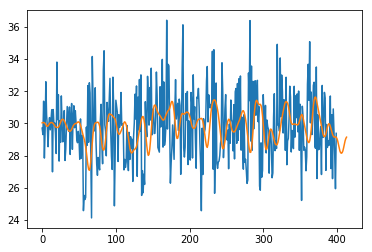

In [19]:
plt.plot(sigmas_f)
plt.plot(smooth(sigmas_f, window_len = 15))

In [20]:
%matplotlib notebook

<IPython.core.display.Javascript object>


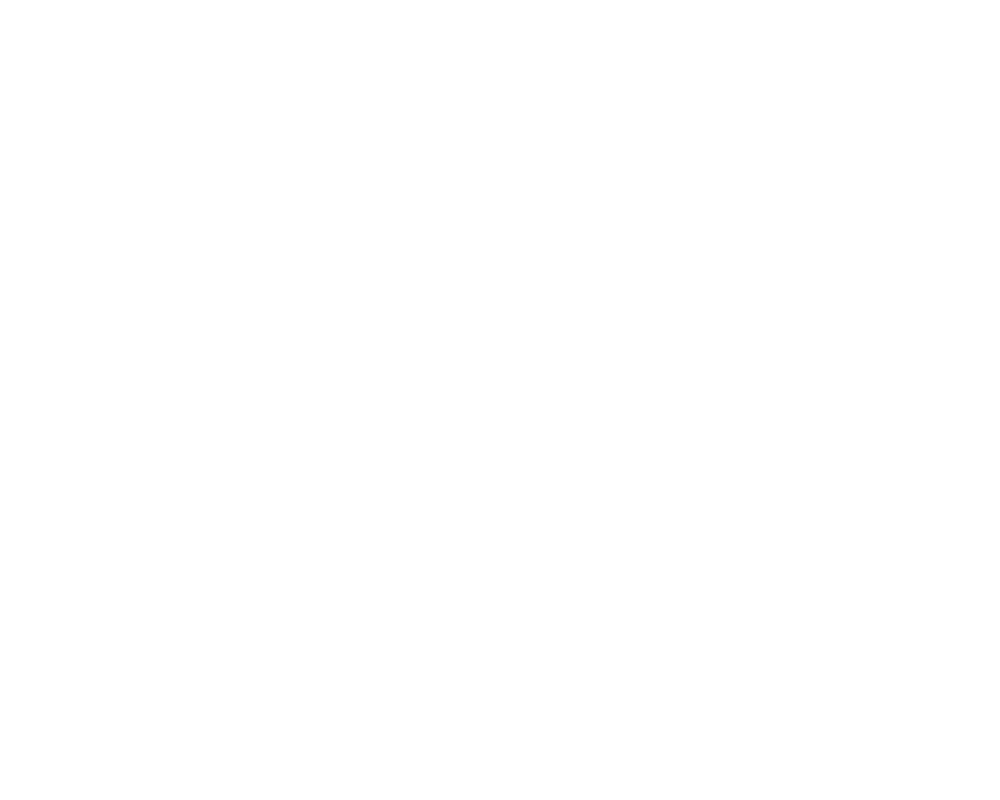

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

def init():
    ax.view_init(elev=35, azim = 0)

def animate(i):
    ax.view_init(elev=35,azim = i/2)
    plt.title('Time (ms) = %s'% i)
    return im


# un peu de masking
'''sigmas_zero[sigmas_zero > vislim] = np.nan
sigmas_f[sigmas_f > vislim] = np.nan
delta_sigmas[delta_sigmas > vislim] = np.nan'''


tri = ax.plot_trisurf(As,
                   taus,
                   smooth(sigmas_f, window_len = 12),
                   #c=np.linspace(min(sigmas_f), max(sigmas_f), sigmas_f.shape[0]),
                   cmap=plt.cm.magma,
                   linewidth=0)


ax.set_zlabel('$\sigma_f$', fontsize=12)
ax.set_xlabel('A *', fontsize=12)
ax.set_ylabel('taus', fontsize=12)
ax.set_title('Gradient des performances du réseau')

ax.xaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
ax.yaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
#ax.zaxis._axinfo["grid"]["color"] = (1,1,1,0)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



im = plt.colorbar(tri)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               interval=1, blit = True, save_count = 800)
anim.save('./figs/gradient_anim.gif', writer = 'imagemagick', dpi = 40, fps = 120)

# Deuxième scan, les ratios d'amplitudes et de taus
Biologiquement et à l'appui des papiers, j'aime bien la petite vallée qu'on voit avec tau approx 25 et A* .002, en ce qui concerne les paramètres du scan précédent

In [22]:
from sklearn.model_selection import ParameterGrid

scan_size = 20
parameters_dico = {'sparseness': np.array([.1]),  #scanned
                   'weight_mu': np.array([1.5]), #scanned
                   'delays_mu': np.array([1.]), #scanned
                   'ratio_weights_EI': np.array([1]), #scanned
                   'stdp_weight_init': np.array([.5]), #scanned
                   'stdp_max_weight': np.array([1]), #scanned
                   'ratio_amps': np.linspace(1,10, scan_size),
                   'ratio_taus': np.linspace(1,10, scan_size),
                   'taus': np.array([25]),
                   'stdp_amps': np.array([.002])}
# ratio multiply the negative part of the duo, ie inhibition, tau minus and A minus

grid = ParameterGrid(parameters_dico)

import datetime

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d-%Hh%M")

# a+ to append and create if not existant
f = open("./output/scan_logs_%s.txt" % strtime, "a+")
f.write('SCANNING PARAMETERS @ '+strtime)
f.close()

In [23]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 2000
rng = sim.NumpyRNG(seed=42)

rate_gain = 10.  # multiplier for the rates
angle_input = 40  # degrees
b_theta = 30  # degrees
sparseness = .1

In [24]:
def run_simulation(sparseness, weight_mu, delays_mu,
                   tau, stdp_amp, stdp_weight_init, stdp_max_weight,
                   ratio_weights_EI, ratio_amps, ratio_taus,
                   filewrite, full_args):

    def vary_angle(t):
        simtime = 2000
        n_pop = 60
        shift = 40

        angle = 1. * np.arange(n_pop)
        rates = tuning_function(
            angle, (t*shift)+(angle_input)/180.*n_pop, b_theta, n_pop)
        rates /= rates.mean()
        rates *= rate_gain
        for i, cell in enumerate(input_pop):
            cell.set_parameters(rate=rates[i])
        return t + simtime/4

    # WEIGHTS
    normal_weights = rnd('normal_clipped', mu=weight_mu, sigma=.2, low=0.1,
                         high=5,
                         rng=rng)
    inh_normal_weights = rnd('normal_clipped', mu=weight_mu*ratio_weights_EI, sigma=.2, low=0.1,
                             high=5,
                             rng=rng)

    # DELAYS
    delays = rnd('normal_clipped', mu=delays_mu, sigma=.2, low=0.1,
                 high=5,
                 rng=rng)

    # STDP
    timing_dependence = sim.SpikePairRule(tau_plus=tau, tau_minus=tau*ratio_taus,
                                          A_plus=stdp_amp, A_minus=stdp_amp*ratio_amps)

    sim.setup(timestep=.1, threads=8)

    # POPULATIONS
    exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Exictateurs")

    inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Inhibiteurs")

    input_pop = sim.Population(n_pop,
                               sim.SpikeSourcePoisson(
                                   rate=500, duration=simtime, start=250),
                               label="Entree Orientation")

    stabilizing_pop = sim.Population(n_pop,
                                     sim.SpikeSourcePoisson(
                                         rate=10, duration=200, start=0),
                                     label="Entree Orientation")

    # SYNAPSES
    STDP_syn = sim.STDPMechanism(
        timing_dependence=timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=stdp_max_weight),
        weight=stdp_weight_init,
        delay=delays,
        dendritic_delay_fraction=1.)

    # Intras
    syn_exc_exc = sim.Projection(exc, exc,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_inh = sim.Projection(inh, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=sim.StaticSynapse(
                                     weight=normal_weights, delay=delays),
                                 receptor_type='inhibitory')  # we can't have two types of synapses now can we ?

    # Inters
    syn_exc_inh = sim.Projection(exc, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_ex = sim.Projection(inh, exc,
                                connector=sim.FixedProbabilityConnector(
                                    sparseness, rng=rng),
                                synapse_type=sim.StaticSynapse(
                                    weight=normal_weights, delay=delays),
                                receptor_type='inhibitory')

    # Input
    syn_inp_exc = sim.Projection(input_pop, exc,
                                 connector=sim.OneToOneConnector(),
                                 synapse_type=sim.StaticSynapse(
                                     weight=1, delay=1),
                                 receptor_type='excitatory')
    sin_stab_exc = sim.Projection(stabilizing_pop, exc,
                                  connector=sim.OneToOneConnector(),
                                  synapse_type=sim.StaticSynapse(
                                      weight=1, delay=1),
                                  receptor_type='excitatory')

    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates *= rate_gain
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    exc.record('spikes')
    inh.record('spikes')
    input_pop.record('spikes')
    sim.run(simtime, callbacks=[vary_angle])
    sim.end()

    exc_data = exc.get_data().segments[0]
    inh_data = inh.get_data().segments[0]
    inp_data = input_pop.get_data().segments[0]

    scan_lst = SuperScanner(SpikesP=inp_data, SpikesE=exc_data, SpikesI=inh_data,
                            popsize=60, rates=rates, simtime=2000)

    # logging
    f = open(filewrite, "a+")
    f.write('\nSigmas\n')
    f.write(str(scan_lst))
    f.write('\nParams\n')
    f.write(str(full_args))
    f.write('\n\n')
    f.close()

    sim.reset()
    return scan_lst, ratio_taus, ratio_amps

In [25]:
import datetime
from tqdm import tqdm

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d-%Hh%M")

scan_output = []
for combination in tqdm(grid):
    sigmas, ratio_tau, ratio_a = run_simulation(sparseness=combination['sparseness'],
                                  weight_mu=combination['weight_mu'],
                                  delays_mu=combination['delays_mu'],
                                  tau=combination['taus'],
                                  stdp_amp=combination['stdp_amps'],
                                  stdp_weight_init=combination['stdp_weight_init'],
                                  stdp_max_weight=combination['stdp_max_weight'],
                                  ratio_weights_EI=combination['ratio_weights_EI'],
                                  ratio_amps=combination['ratio_amps'],
                                  ratio_taus=combination['ratio_taus'],
                                  filewrite='./output/scan_logs_%s.txt' % strtime,
                                  full_args=combination)
    scan_output.append([sigmas, ratio_tau, ratio_a])

  0%|          | 1/400 [00:01<09:48,  1.47s/it]/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/recording/__init__.py:264: UserWarning: Recorded at least one spike after t_stop
  warn("Recorded at least one spike after t_stop")
100%|██████████| 400/400 [10:41<00:00,  1.42s/it]


In [26]:
sigmas_zero, sigmas_f, delta_sigmas, ratio_taus, ratio_As = [],[],[], [],[]
for scan in scan_output :
    sigma_zero = scan[0][0]
    sigma_f = scan[0][-1]
    delta_sigma = sigma_zero - sigma_f
    
    sigmas_zero.append(sigma_zero)
    sigmas_f.append(sigma_f)
    delta_sigmas.append(delta_sigma)
    
    ratio_taus.append(scan[1])
    ratio_As.append(scan[-1])
    
sigmas_zero = np.asarray(sigmas_zero)
sigmas_f = np.asarray(sigmas_f)
delta_sigmas = np.asarray(delta_sigmas)

In [27]:
%matplotlib notebook

Traceback (most recent call last):
  File "/home/hugo/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/hugo/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


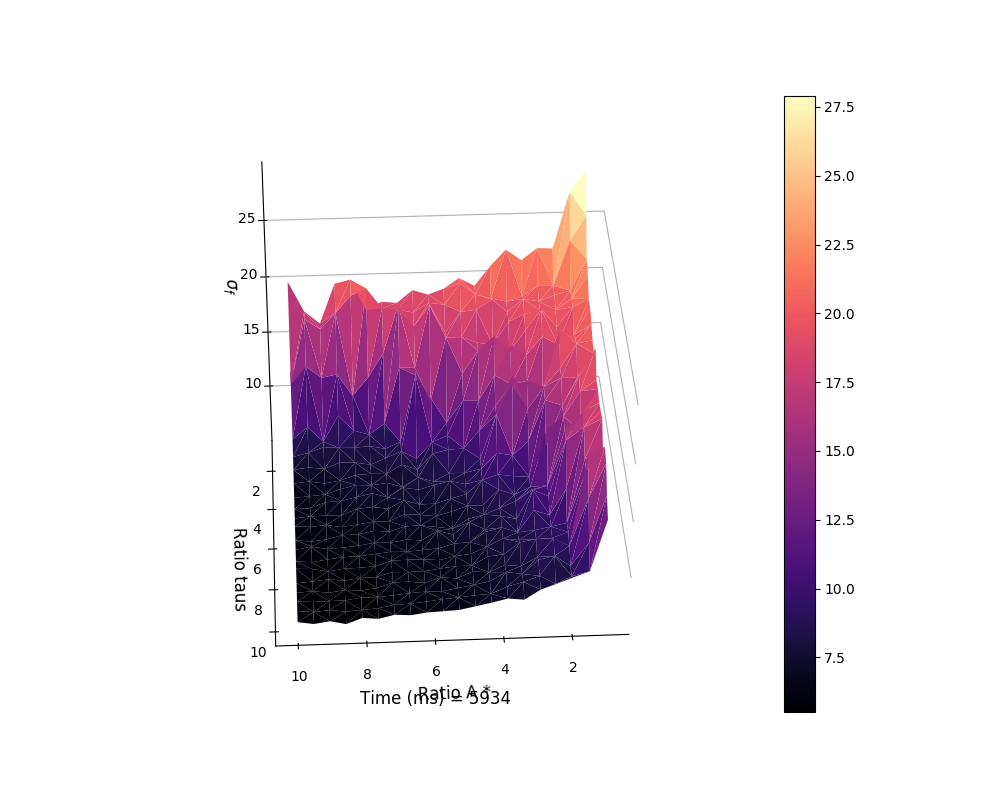

In [37]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

def init():
    ax.view_init(elev=35, azim = 0)

def animate(i):
    ax.view_init(elev=35,azim = i/2)
    plt.title('Time (ms) = %s'% i)
    return im


# un peu de masking
'''sigmas_zero[sigmas_zero > vislim] = np.nan
sigmas_f[sigmas_f > vislim] = np.nan
delta_sigmas[delta_sigmas > vislim] = np.nan'''


tri = ax.plot_trisurf(ratio_As,
                   ratio_taus,
                   sigmas_f,
                   #c=np.linspace(min(sigmas_f), max(sigmas_f), sigmas_f.shape[0]),
                   cmap=plt.cm.magma,
                   linewidth=0)


ax.set_zlabel('$\sigma_f$', fontsize=12)
ax.set_xlabel('Ratio A *', fontsize=12)
ax.set_ylabel('Ratio taus', fontsize=12)
ax.set_title('Gradient des performances du réseau\nLe ratio est un multiplicateur de A- et $\\tau$-')

ax.xaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
ax.yaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
#ax.zaxis._axinfo["grid"]["color"] = (1,1,1,0)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



im = plt.colorbar(tri)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               interval=1, blit = True, save_count = 800)
anim.save('./figs/gradient_ratio_anim.gif', writer = 'imagemagick', dpi = 40, fps = 120)